In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


FFHQ dataset

In [ ]:
%cd drive/MyDrive/

/content/drive/MyDrive


In [ ]:
import os
import cv2
import numpy as np
import random
from google.colab.patches import cv2_imshow
np.random.seed(42)

In [ ]:
data_path = 'poc'
faces_path = os.path.join(data_path, 'cropped')
masks_path = os.path.join(data_path, 'SegmentationClass')
masks_list = os.listdir(masks_path)

In [ ]:
%ls

 cam.jpg                   exp3/                  poc/
'Colab Notebooks'/         eye_train/             resultats_yolo/
 Docs/                     LM/                    table_ext/
'document de test'/        marmot_dataset_v1.0@   UTKFace/
 DS/                       marmot_tablenet@      'UTKface_Aligned&cropped'@
'Earthquake prediction'/   masks/                 UTKFace.tar.gz
'Epson iPrint'/            model.png              val/


In [ ]:
sample = random.sample(masks_list, 5)

In [ ]:
sample

['00067.png', '00145.png', '00559.png', '00065.png', '00074.png']

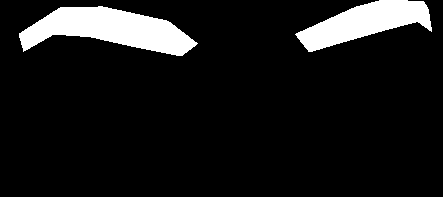

In [ ]:
a = cv2.imread(os.path.join(masks_path, sample[0]))
cv2_imshow(a)

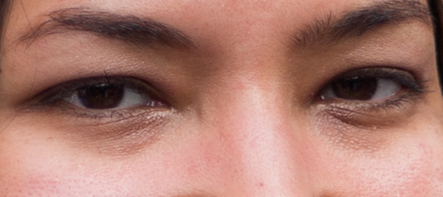

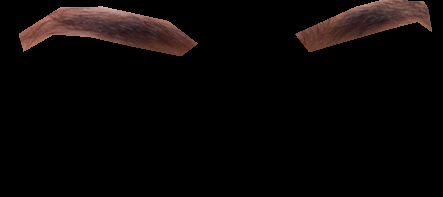

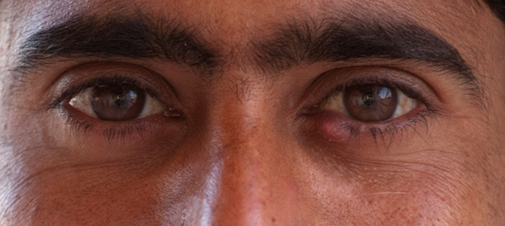

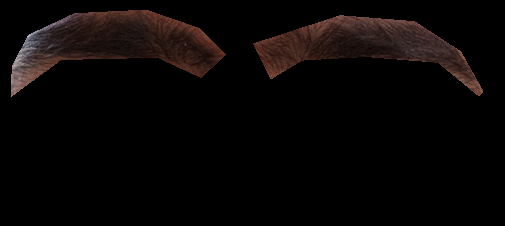

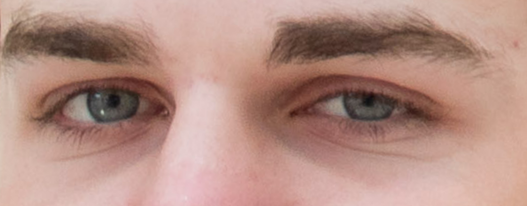

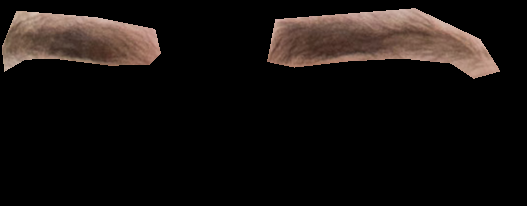

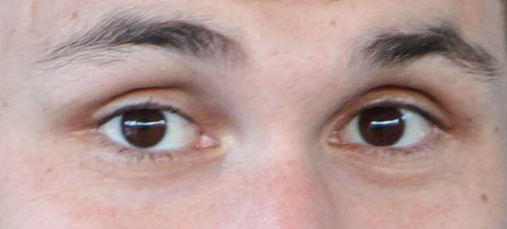

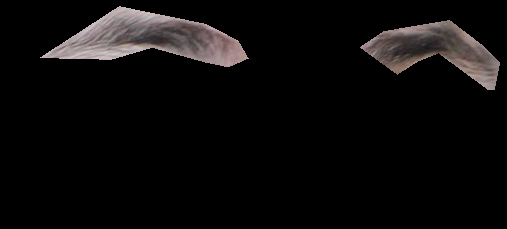

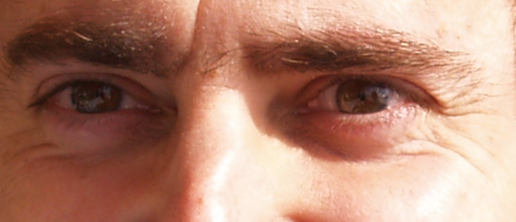

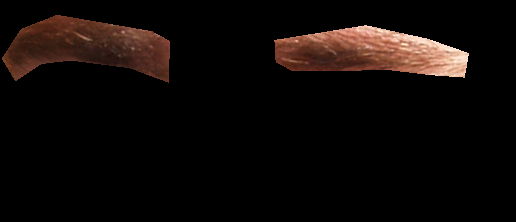

In [ ]:
for filename in sample:
  img_path = os.path.join(faces_path, filename)
  mask_path = os.path.join(masks_path, filename)
  img = cv2.imread(img_path)
  mask = cv2.imread(mask_path)
  #mask[np.where((mask != [0 , 0 , 0]).all(axis=2))] = [255, 255, 255]
  mask=mask[:, :, 0]
  cv2_imshow(img)
  res = cv2.bitwise_and(img, img, mask=mask)
  cv2_imshow(res)

In [ ]:
X = []
y = []

for filename in masks_list:
  img_path = os.path.join(faces_path, filename)
  mask_path = os.path.join(masks_path, filename)
  img = cv2.imread(img_path)
  mask = cv2.imread(mask_path)
  #mask = cv2.resize(mask, (256, 256))
  #(thresh, blackAndWhiteImage) = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

  X.append(cv2.resize(img, (512, 256)))
  y.append(cv2.resize(mask, (512, 256)))  #[:, :, 0]

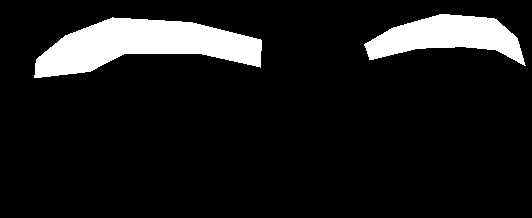

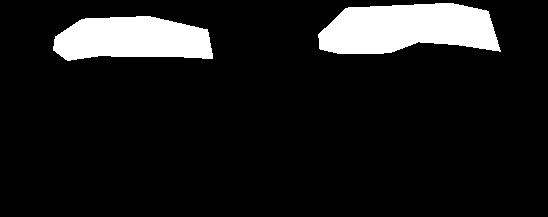

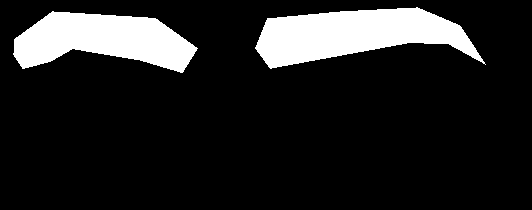

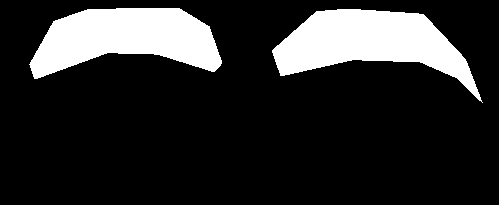

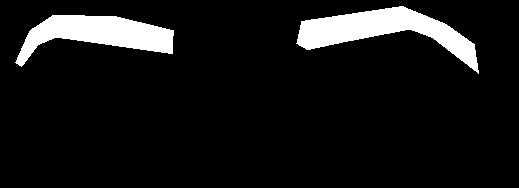

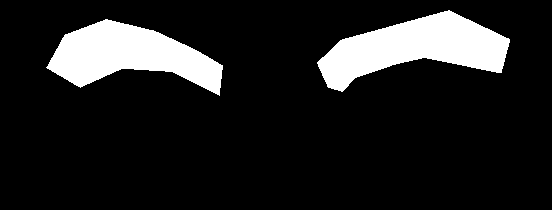

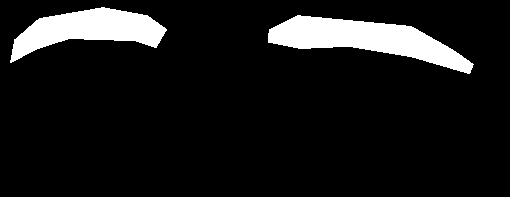

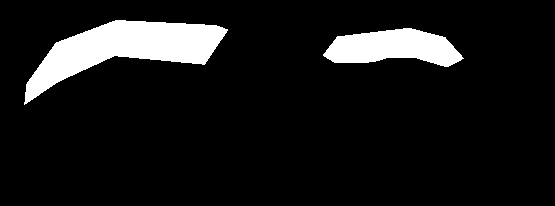

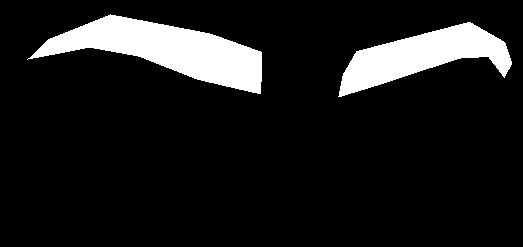

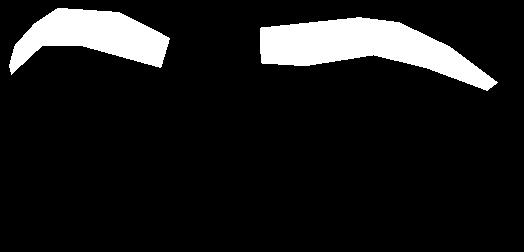

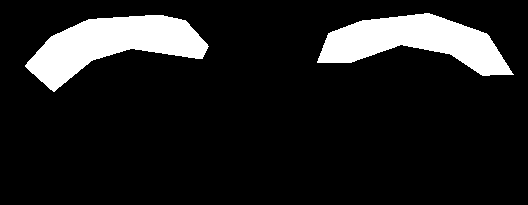

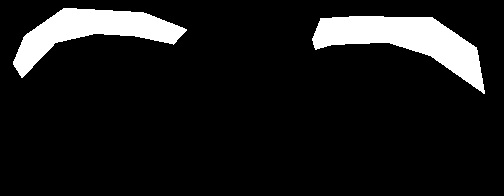

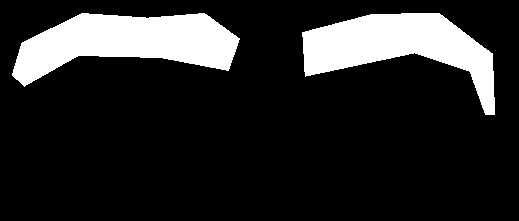

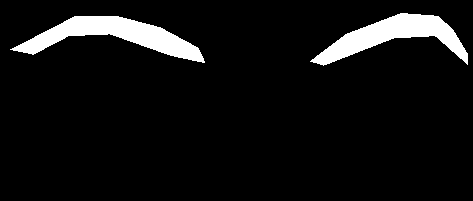

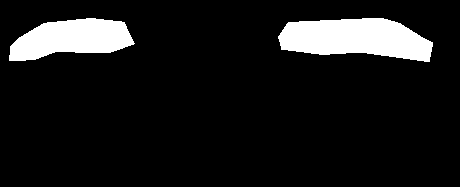

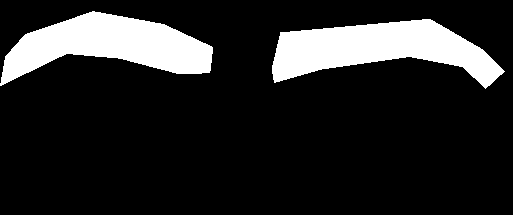

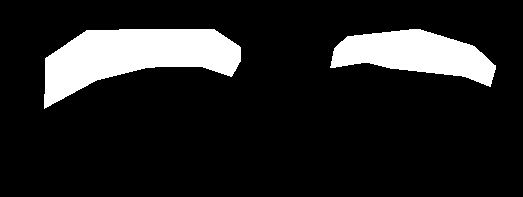

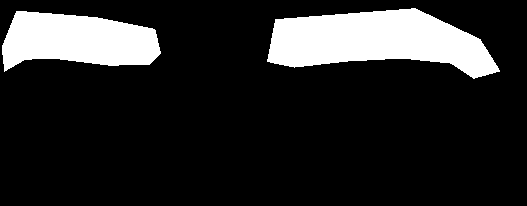

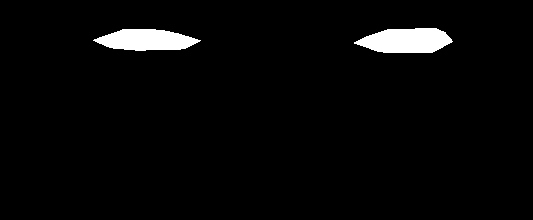

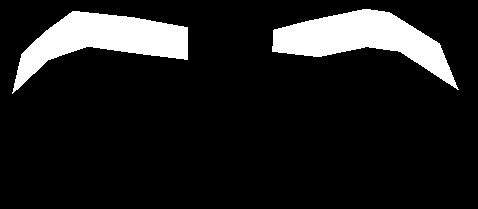

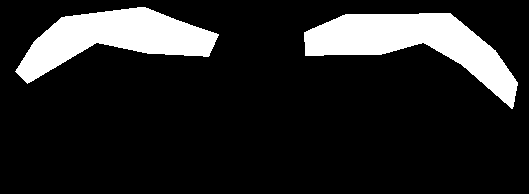

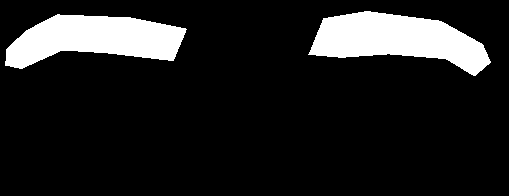

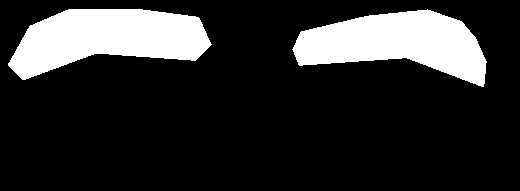

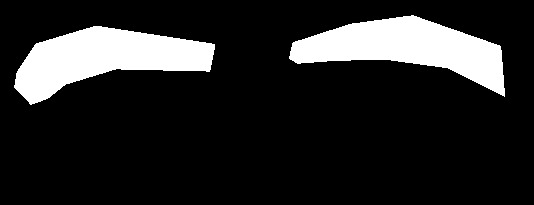

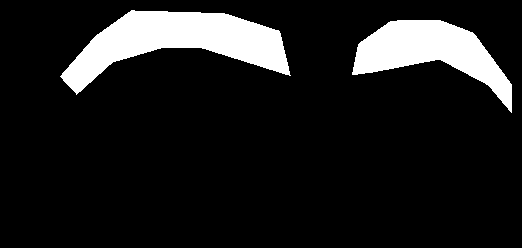

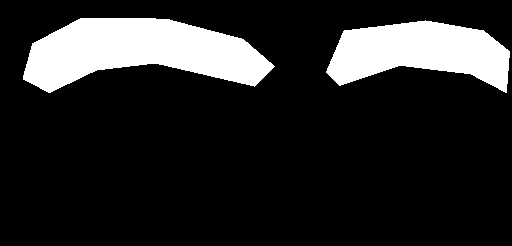

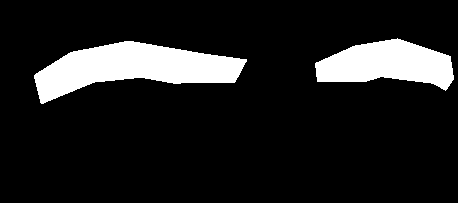

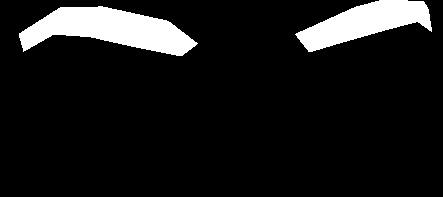

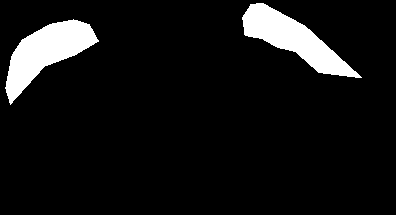

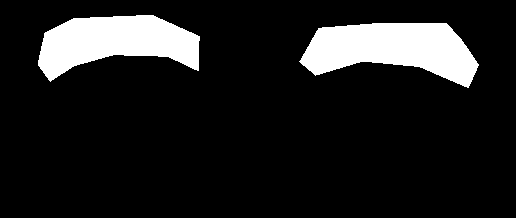

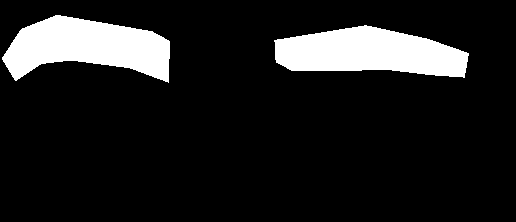

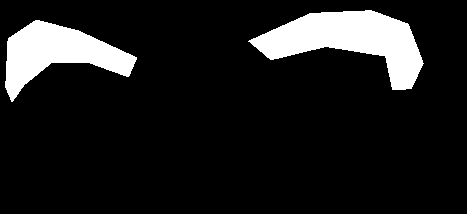

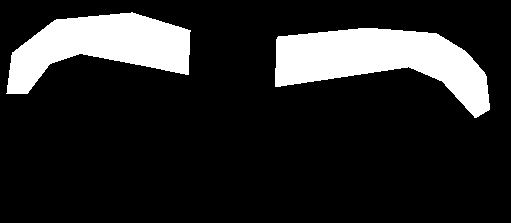

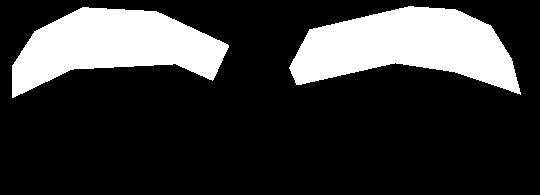

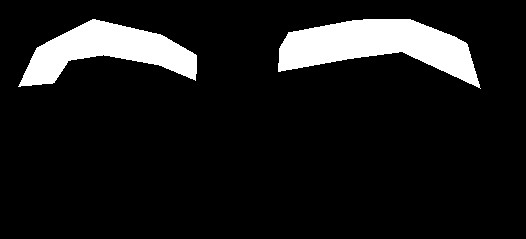

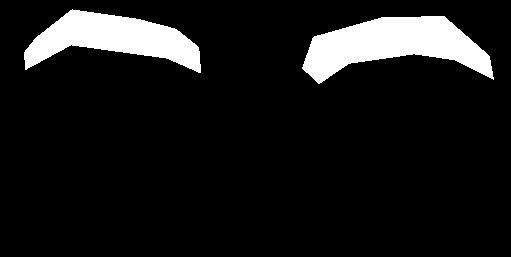

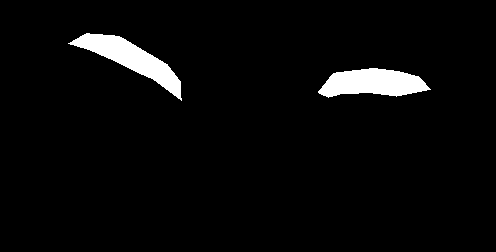

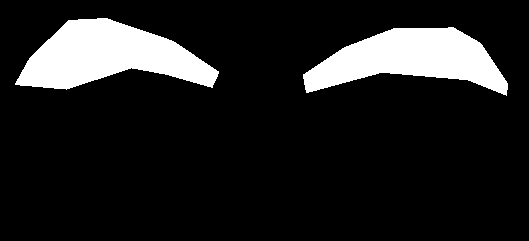

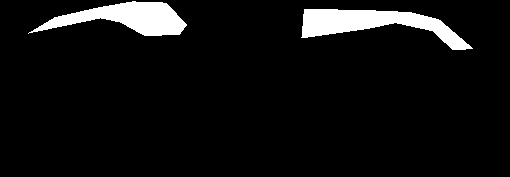

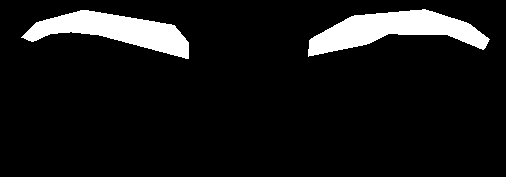

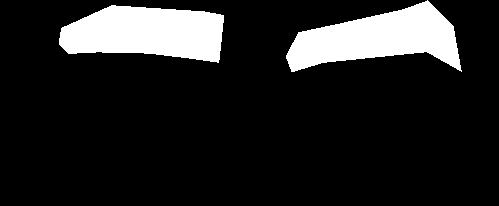

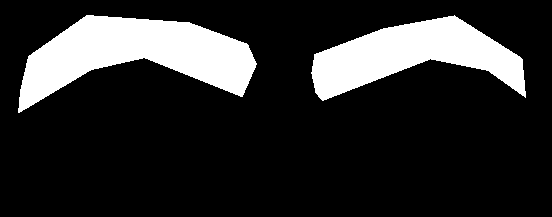

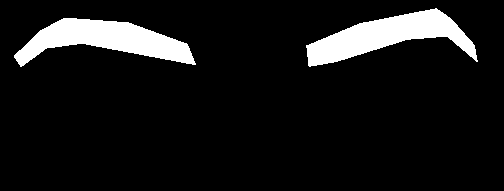

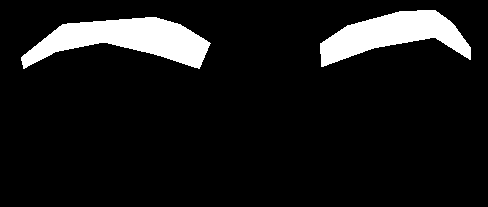

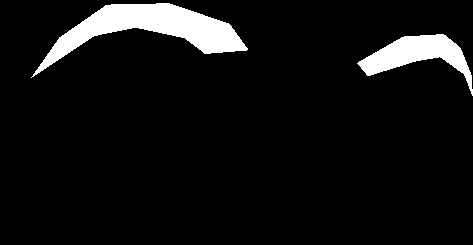

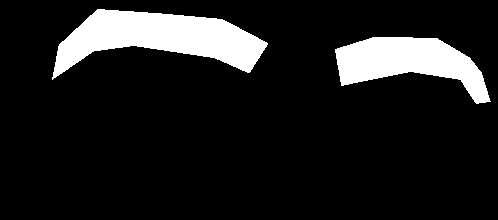

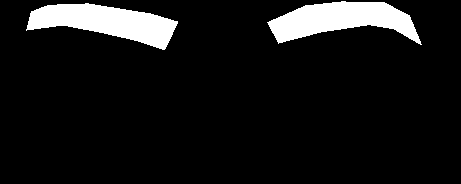

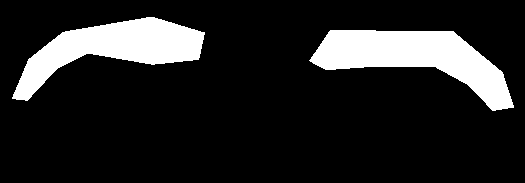

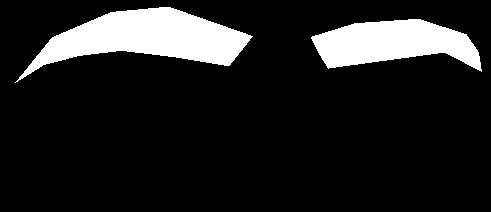

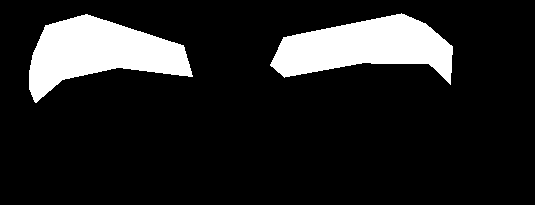

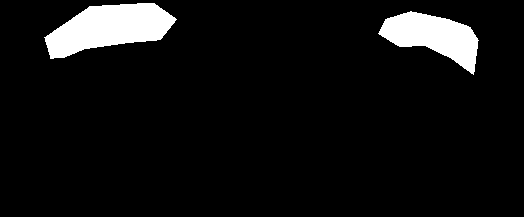

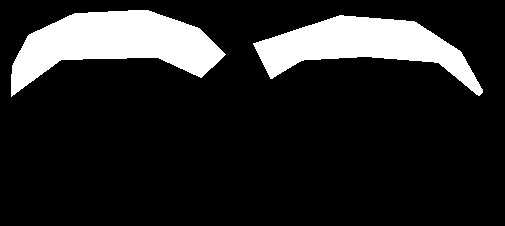

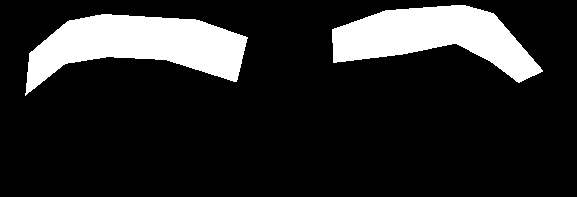

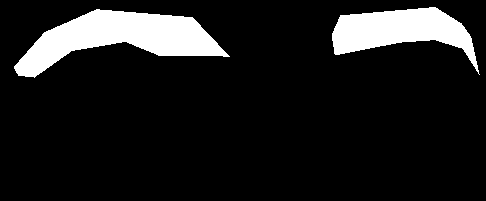

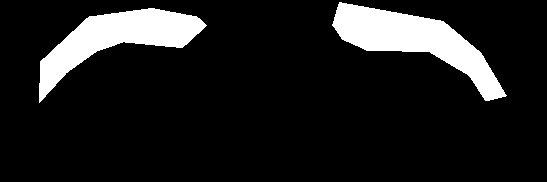

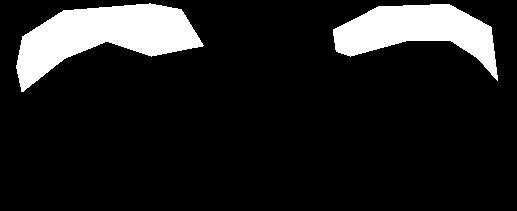

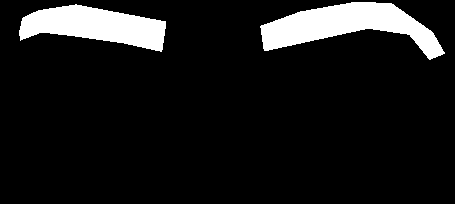

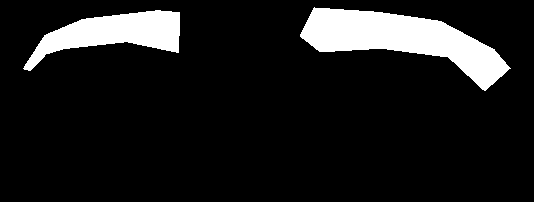

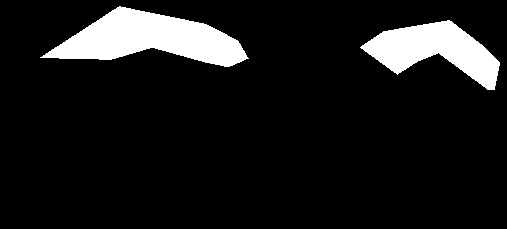

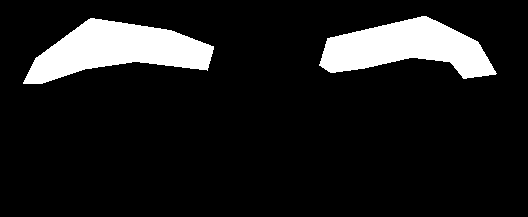

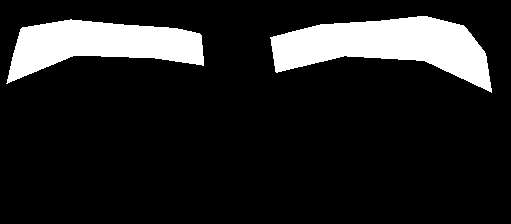

In [ ]:
for filename in masks_list:
  img_path = os.path.join(faces_path, filename)
  mask_path = os.path.join(masks_path, filename)
  img = cv2.imread(img_path)
  mask = cv2.imread(mask_path)
  #mask[np.where((mask != [0 , 0 , 0]).all(axis=2))] = [255, 255, 255]
  mask=mask[:, :, 0]
  cv2_imshow(mask)
  res = cv2.bitwise_and(img, img, mask=mask)
  cv2.imwrite(os.path.join(data_path, 'eyebrows', filename), res)

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train = np.array(X_train)/255
X_test = np.array(X_test)/255
y_train = np.array(y_train)/255
y_test = np.array(y_test)/255

In [ ]:
y[0].shape

(256, 512, 3)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input, Concatenate, UpSampling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import backend as K

smooth = 1.0

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

class EyeBrowsNet:
  @staticmethod
  def build_decoder(inputs, pool3, pool4):
    x = Conv2D(512, (1, 1), activation = 'relu', name='conv7')(inputs)
    x = UpSampling2D(size=(2, 2))(x)

    concatenated = Concatenate()([x, pool4])
    x = UpSampling2D(size=(2,2))(concatenated)
    
    concatenated = Concatenate()([x, pool3])

    x = UpSampling2D(size=(2,2))(concatenated)
    x = UpSampling2D(size=(2,2))(x)

    last = tf.keras.layers.Conv2DTranspose(
      3, 3, strides=2, activation='relu',
      padding='same', name='output') 

    x = last(x)

    return x
    
  @staticmethod
  def vgg_base(inputs):
    base_model = tf.keras.applications.vgg19.VGG19(
        input_shape=[256, 512, 3],
        include_top=False, weights='imagenet')
    
    layer_names = ['block3_pool', 'block4_pool', 'block5_pool']
    layers = [base_model.get_layer(name).output for name in layer_names]

    pool_layers_model = Model(inputs=base_model.input, outputs=layers, name='VGG-19')
    pool_layers_model.trainable = False

    return pool_layers_model(inputs)
  
  @staticmethod
  def build():
    inputShape = (256, 512, 3)

    inputs = Input(shape=inputShape, name='input')
    pool_layers = EyeBrowsNet.vgg_base(inputs)

    x = Conv2D(512, (1, 1), activation='relu', name='block6_conv1')(pool_layers[2])
    #x = Dropout(0.65, name='block6_dropout1')(x)
    x = Conv2D(512, (1, 1), activation='relu', name='block6_conv2')(pool_layers[2])
    #x = Dropout(0.65, name='block6_dropout2')(x)

    mask = EyeBrowsNet.build_decoder(x, pool_layers[0], pool_layers[1])
    model = Model(			
              inputs=inputs,
			        outputs=[mask],
			        name="eyebrowsnet")
    
    return model


model = EyeBrowsNet.build()
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=dice_coef_loss,
              metrics=[dice_coef])

history = model.fit(X_train, y_train, epochs=5, batch_size=4)

80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/5
12/12 [==============================] - 85s 7s/step - loss: -0.4787 - dice_coef: 0.4830
Epoch 2/5
12/12 [==============================] - 83s 7s/step - loss: -1.2390 - dice_coef: 1.2419
Epoch 3/5
12/12 [==============================] - 83s 7s/step - loss: -1.4688 - dice_coef: 1.4677
Epoch 4/5
12/12 [==============================] - 87s 7s/step - loss: -1.5468 - dice_coef: 1.5434
Epoch 5/5
12/12 [==============================] - 85s 7s/step - loss: -1.6076 - dice_coef: 1.6068


In [ ]:
model.summary()

Model: "eyebrowsnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 256, 512, 3) 0                                            
__________________________________________________________________________________________________
VGG-19 (Functional)             [(None, 32, 64, 256) 20024384    input[0][0]                      
__________________________________________________________________________________________________
block6_conv2 (Conv2D)           (None, 8, 16, 512)   262656      VGG-19[0][2]                     
__________________________________________________________________________________________________
conv7 (Conv2D)                  (None, 8, 16, 512)   262656      block6_conv2[0][0]               
________________________________________________________________________________________

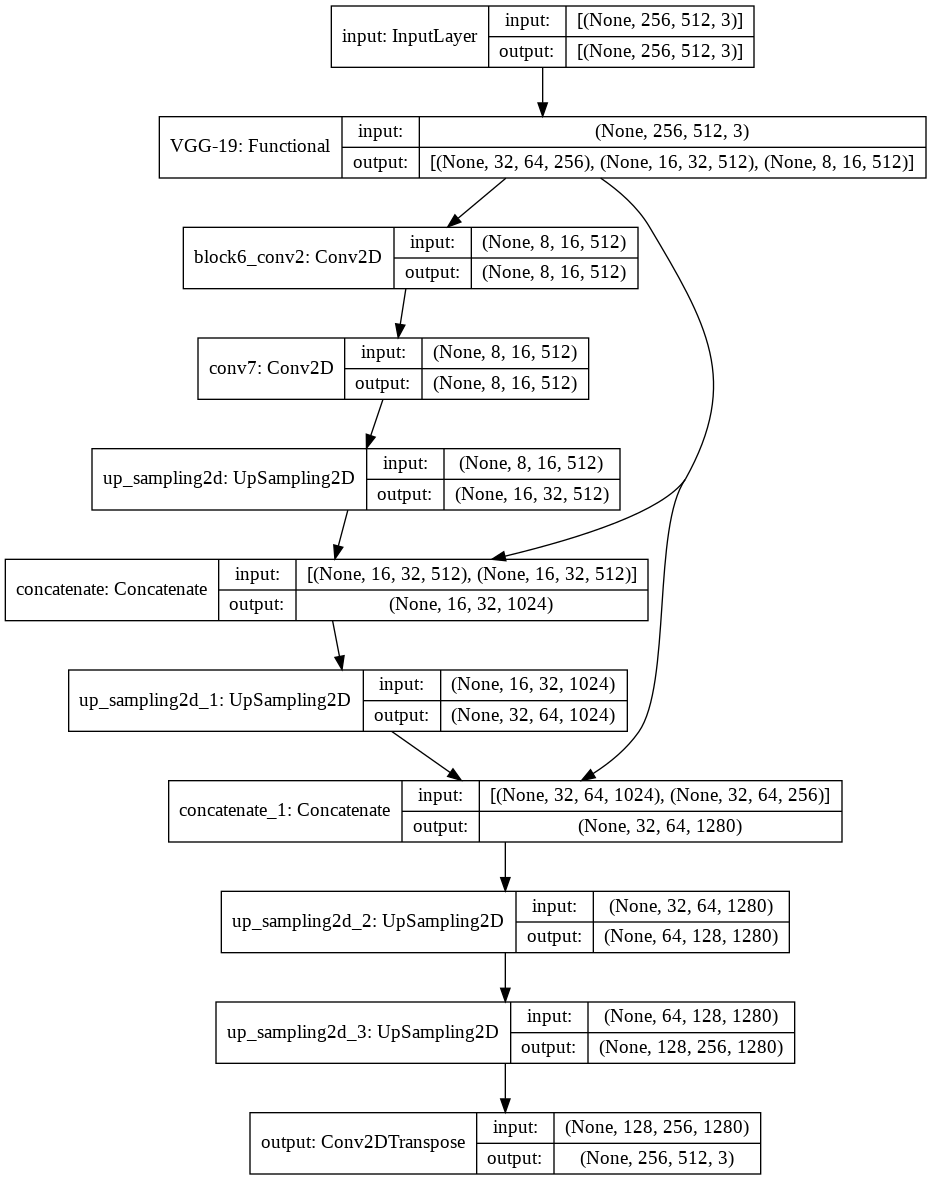

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
preds = model.predict(X_test)

In [ ]:
import matplotlib.pyplot as plt
num_test = 13 #0, 1, 4, 5, 6, 10, 11, 12, 13 

def show_prediction(num_sample, alpha=0.5):
  img1 = X_test[num_sample]*255
  img2 = preds[num_sample]
  gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
  a = np.zeros_like(img2)
  a[:,:,0] = gray
  a[:,:,1] = gray
  a[:,:,2] = gray
  (thresh, msk) = cv2.threshold(a, 1, 255, cv2.THRESH_BINARY)
  vis = msk * alpha + img1
  cv2_imshow(vis)

In [ ]:
tests = [0, 1, 4, 5, 6, 10, 11, 12, 13]
for num_sample in tests:
  show_prediction(num_sample)

Output hidden; open in https://colab.research.google.com to view.